In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import chart_studio.plotly as ply
import cufflinks as cf
from arch import arch_model
from tbats import BATS, TBATS
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'medium',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small',
          'lines.linewidth' : 1.6}
plt.rcParams.update(params)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_us = pd.read_csv('us.csv')

In [3]:
df_us.dtypes

date      object
cases      int64
deaths     int64
dtype: object

In [4]:
df_us['date'] = pd.to_datetime(df_us['date'])
df_us.set_index('date', inplace = True)

In [5]:
df_us.shape

(244, 2)

In [6]:
df_us.head()

,cases,deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


<AxesSubplot:title={'center':'Number of Cases in United States'}, xlabel='Date'>

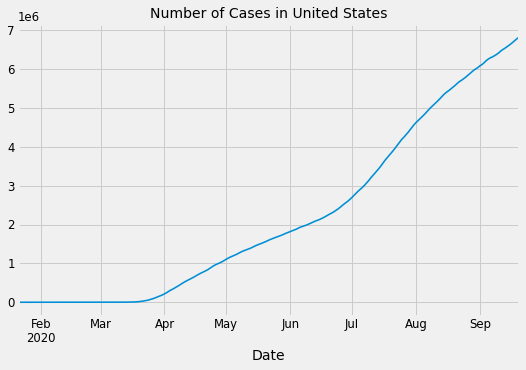

In [7]:
df_us['cases'].plot(xlabel = 'Date', title = 'Number of Cases in United States')

In [8]:
df_us['case_day'] = df_us['cases'].diff()
df_us['case_day'][0] = 1
df_us['case_day'] =  df_us['case_day'].astype('int')

In [9]:
df_us['case_day']

date
2020-01-21        1
2020-01-22        0
2020-01-23        0
2020-01-24        1
2020-01-25        1
              ...  
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, Length: 244, dtype: int32

In [10]:
df_us['case_day'].describe()

count      244.000000
mean     27974.430328
std      20905.013735
min          0.000000
25%       8037.750000
50%      26623.000000
75%      43426.250000
max      75682.000000
Name: case_day, dtype: float64

<AxesSubplot:title={'center':'Number of New Cases'}, xlabel='Date', ylabel='New Cases per Day'>

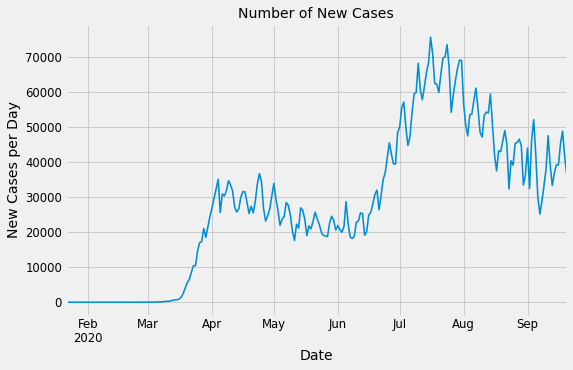

In [11]:
df_us['case_day'].plot(ylabel = 'New Cases per Day', xlabel = 'Date', title = 'Number of New Cases')

<AxesSubplot:xlabel='date'>

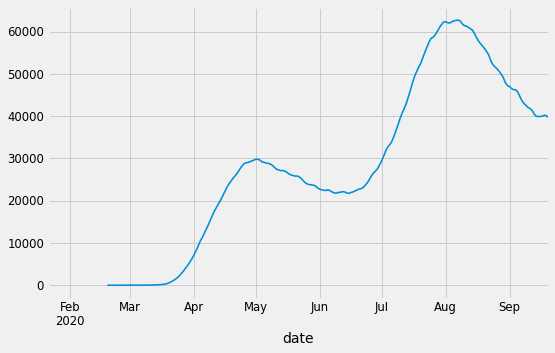

In [12]:
df_us['case_day'].rolling(30).mean().plot()

In [13]:
df_us[df_us['case_day'] == df_us['case_day'].max()]

,cases,deaths,case_day
date,,,
2020-07-16,3589349,138284,75682


In [14]:
test = adfuller(df_us['case_day'])
test_cases_day = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_cases_day)
# P-value > 0.05 Not Stationary


Test Statstic                   -1.803998
p-value                          0.378478
#Lags Used                       0.000000
Number of Observations Used    243.000000
dtype: float64


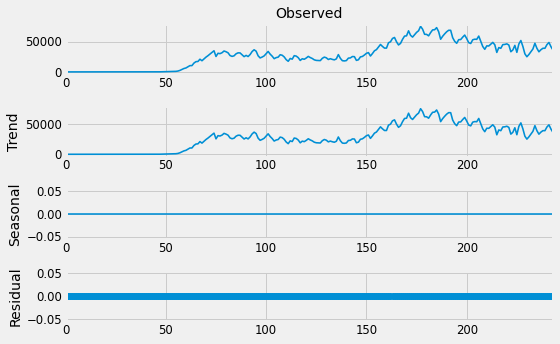

In [15]:
sd = seasonal_decompose(np.array(df_us['case_day']), model='additive', freq=1)
sd.plot()
plt.show()

## Differencing 


In [16]:
diff1 = df_us['case_day'] - df_us['case_day'].shift(1)

In [17]:
diff1 = diff1.dropna()

In [18]:
test = adfuller(diff1)
test_diff1 = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_diff1)
# pvalue still < 0.05 
# Series Stationary

Test Statstic                 -1.408123e+01
p-value                        2.826384e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.420000e+02
dtype: float64


<AxesSubplot:title={'center':'Differenced Series'}, xlabel='Date', ylabel='New Cases per Day'>

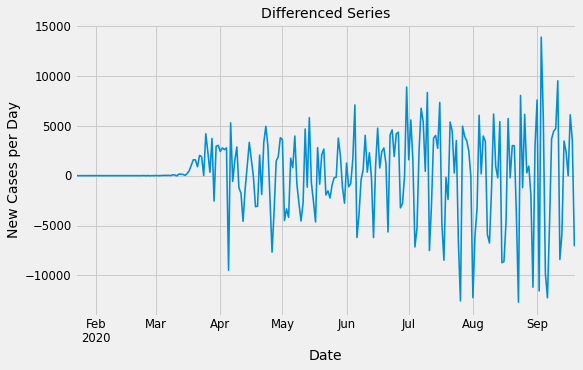

In [19]:
diff1.plot(ylabel = 'New Cases per Day', xlabel = 'Date', title = 'Differenced Series')

## Plotting ACF and PACF

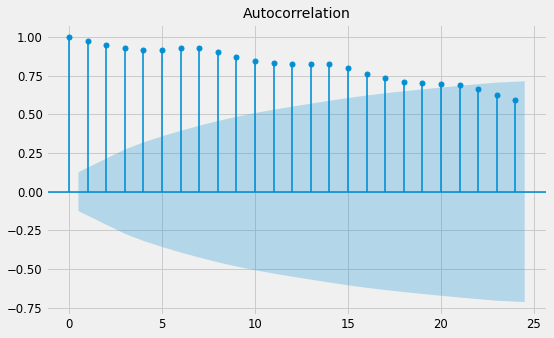

In [20]:
plot_acf(df_us['case_day'], alpha = 0.05) # q = 1-20
plt.show()

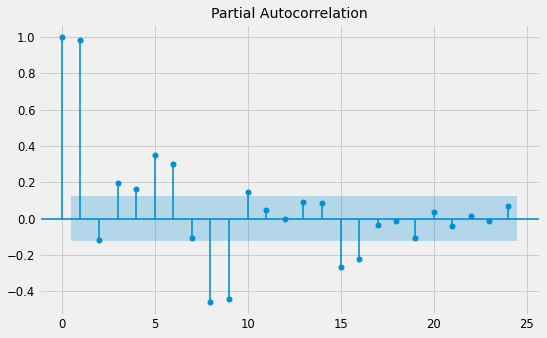

In [21]:
plot_pacf(df_us['case_day'], alpha = 0.05) # p = 3
plt.show()

## Train Test Split

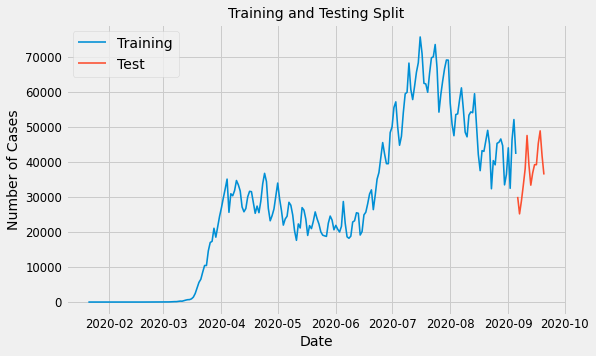

In [22]:
train = df_us['case_day'].loc['2020-01-21':'2020-09-05']
test = df_us['case_day'].loc['2020-09-06':]
fig, ax = plt.subplots()
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Training and Testing Split')
plt.show()

## BASELINE NAIVE

In [23]:
naive_preds = test.copy()
naive_preds.values[:] = train[len(train)-1]

In [24]:
naive_preds

date
2020-09-06    42278
2020-09-07    42278
2020-09-08    42278
2020-09-09    42278
2020-09-10    42278
2020-09-11    42278
2020-09-12    42278
2020-09-13    42278
2020-09-14    42278
2020-09-15    42278
2020-09-16    42278
2020-09-17    42278
2020-09-18    42278
2020-09-19    42278
2020-09-20    42278
Name: case_day, dtype: int32

In [25]:
naive_RMSE = np.sqrt(mean_squared_error(naive_preds, test))
print('Naive RMSE: ', naive_RMSE)

Naive RMSE:  8056.436222052527


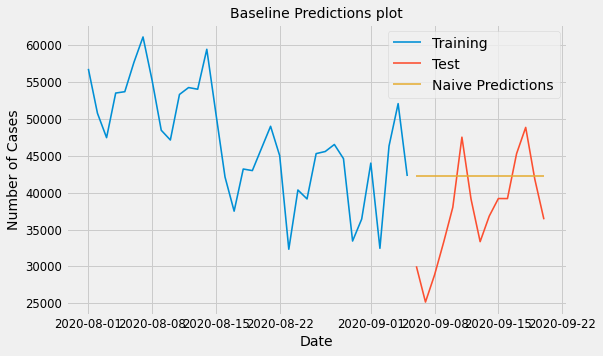

In [26]:
fig, ax = plt.subplots()
plt.plot(train.loc['2020-08-01':'2020-09-05'], label = 'Training')
plt.plot(test, label = 'Test')
plt.plot(naive_preds, label = 'Naive Predictions')
plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Baseline Predictions plot')
plt.show()

## ARIMA model

In [28]:
arima = ARIMA(train, order=(2, 2, 2))
arima_fit = arima.fit(disp= 0)
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D2.case_day   No. Observations:                  227
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -2183.376
Method:                       css-mle   S.D. of innovations           3609.183
Date:                Thu, 24 Sep 2020   AIC                           4378.752
Time:                        17:49:45   BIC                           4399.301
Sample:                    01-23-2020   HQIC                          4387.044
                         - 09-05-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2530     22.727      0.055      0.956     -43.290      45.796
ar.L1.D2.case_day     0.7132      0.070     10.235      0.000       0.577       0.850
ar.L2.D2.case_day    -0.3839      0.068     -5.623      0.000      -0.518      -0.250
ma.L1.D2.case_day    -1.7468      0.041    -42.552      0.000      -1.827      -1.666
ma.L2.D2.case_day     0.8098      0.043     18.951      0.000       0.726       0.894
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9289           -1.3198j            1.6139           -0.1524
AR.2            0.9289           +1.3198j            1.6139            0.1524
MA.1            1.0785           -0.2677j            1.1112           -0.0387
MA.2            1.0785           +0.2677j            1.1112            0.0387
-----------------------------------------------------------------------------
"""

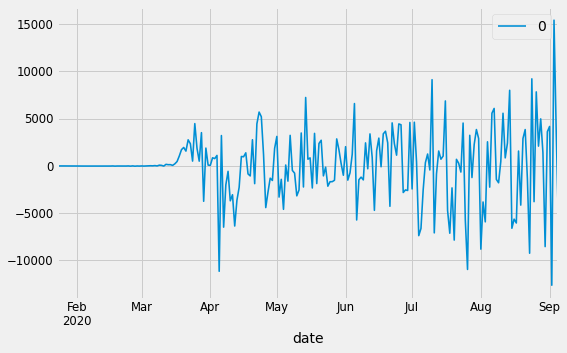

In [29]:
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
plt.show()

In [30]:
preds = test.copy()
preds = preds.replace(preds.values,  arima_fit.forecast(steps = 15)[0])

In [31]:
preds

date
2020-09-06    38363.668403
2020-09-07    39532.858774
2020-09-08    42060.048761
2020-09-09    43604.979665
2020-09-10    43928.851619
2020-09-11    43759.805796
2020-09-12    43708.830544
2020-09-13    43932.140622
2020-09-14    44306.582676
2020-09-15    44684.351032
2020-09-16    45007.310737
2020-09-17    45290.744307
2020-09-18    45567.869933
2020-09-19    45856.511687
2020-09-20    46156.628835
Name: case_day, dtype: float64

In [32]:
np.sqrt(mean_squared_error(preds, test))

8076.825512983111

In [33]:
df_us['case_day'].describe()

count      244.000000
mean     27974.430328
std      20905.013735
min          0.000000
25%       8037.750000
50%      26623.000000
75%      43426.250000
max      75682.000000
Name: case_day, dtype: float64

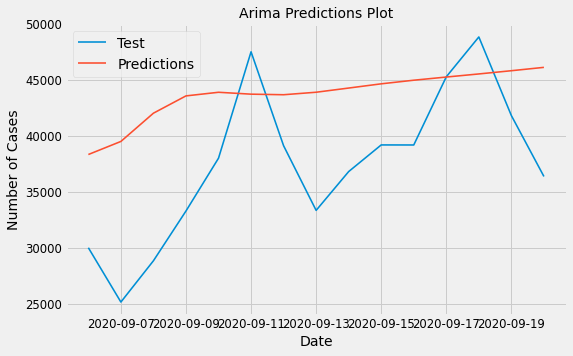

In [34]:
fig, ax = plt.subplots()
plt.plot(test, label = 'Test')
plt.plot(preds, label = 'Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(loc = 'upper left')
plt.title('Arima Predictions Plot')
plt.show()

### Grid Search for ARIMA

In [ ]:
np.isfinite(train).all()

In [ ]:
len(train)

## ARIMA (7, 1 ,6)

In [36]:
best_arima = ARIMA(train, order=(7, 1, 6), exog=None)
best_arima_fit = best_arima.fit()


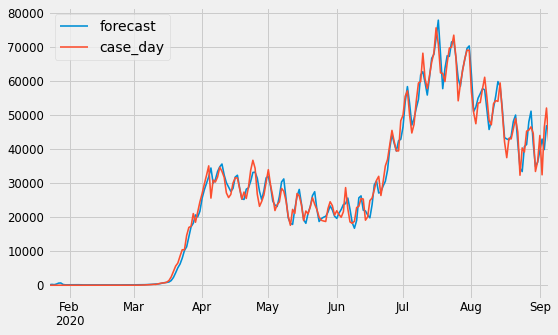

In [37]:
best_arima_fit.plot_predict()
plt.show()

In [40]:
preds = test.copy()
preds = preds.replace(preds.values,  best_arima_fit.forecast(steps = 15)[0])

In [41]:
best_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.case_day   No. Observations:                  228
Model:                 ARIMA(7, 1, 6)   Log Likelihood               -2125.942
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 24 Sep 2020   AIC                           4281.885
Time:                        17:50:07   BIC                           4333.325
Sample:                    01-22-2020   HQIC                          4302.639
                         - 09-05-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              185.4505        nan        nan        nan         nan         nan
ar.L1.D.case_day     0.3445   9.19e-06   3.75e+04      0.000       0.344       0.344
ar.L2.D.case_day    -0.1610        nan        nan        nan         nan         nan
ar.L3.D.case_day    -0.1997   1.81e-06   -1.1e+05      0.000      -0.200      -0.200
ar.L4.D.case_day     0.3565   1.61e-05   2.22e+04      0.000       0.356       0.357
ar.L5.D.case_day    -0.6319        nan        nan        nan         nan         nan
ar.L6.D.case_day     0.5774   4.03e-06   1.43e+05      0.000       0.577       0.577
ar.L7.D.case_day     0.3947        nan        nan        nan         nan         nan
ma.L1.D.case_day    -0.6916      0.049    -14.005      0.000      -0.788      -0.595
ma.L2.D.case_day     0.4061      0.048      8.546      0.000       0.313       0.499
ma.L3.D.case_day     0.0072      0.057      0.126      0.900      -0.105       0.120
ma.L4.D.case_day    -0.4339      0.041    -10.459      0.000      -0.515      -0.353
ma.L5.D.case_day     0.8711      0.062     14.010      0.000       0.749       0.993
ma.L6.D.case_day    -0.6281      0.054    -11.598      0.000      -0.734      -0.522
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0664           -0.0000j            1.0664           -0.0000
AR.2            0.6289           -0.7775j            1.0000           -0.1418
AR.3            0.6289           +0.7775j            1.0000            0.1418
AR.4           -0.2219           -0.9751j            1.0000           -0.2856
AR.5           -0.2219           +0.9751j            1.0000            0.2856
AR.6           -1.0247           -0.0000j            1.0247           -0.5000
AR.7           -2.3186           -0.0000j            2.3186           -0.5000
MA.1           -1.0180           -0.0000j            1.0180           -0.5000
MA.2           -0.1825           -0.9905j            1.0072           -0.2790
MA.3           -0.1825           +0.9905j            1.0072            0.2790
MA.4            0.7616           -0.8103j            1.1121           -0.1299
MA.5            0.7616           +0.8103j            1.1121            0.1299
MA.6            1.2467           -0.0000j            1.2467           -0.0000
-----------------------------------------------------------------------------
"""

In [42]:
best_rmse = np.sqrt(mean_squared_error(preds, test))
print('Best ARIMA RMSE: ',best_rmse)

Best ARIMA RMSE:  5528.68075986263


In [43]:
preds

date
2020-09-06    36615.304620
2020-09-07    36765.994421
2020-09-08    39297.713592
2020-09-09    39733.493770
2020-09-10    45984.279337
2020-09-11    50194.654702
2020-09-12    44271.731781
2020-09-13    36772.611245
2020-09-14    37835.745107
2020-09-15    39453.065567
2020-09-16    40404.995019
2020-09-17    46286.854246
2020-09-18    51255.306375
2020-09-19    45126.204652
2020-09-20    38071.547742
Name: case_day, dtype: float64

In [44]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36839
2020-09-15    39221
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, dtype: int32

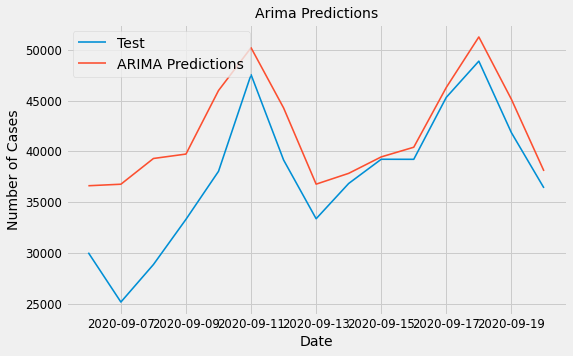

In [45]:
plt.plot(test, label = 'Test')
plt.plot(preds, label = 'ARIMA Predictions')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Arima Predictions')
plt.show()

## AUTO ARIMA

In [46]:
model_auto = auto_arima(train, start_p=1, start_q=1, d = 1,
                           max_p=20, max_q=20, trace=True,
                       error_action='ignore',  m = 1,
                           suppress_warnings=True, scoring = 'mse')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4423.556, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4425.618, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4427.290, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4427.136, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4424.126, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4408.291, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4420.824, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4404.840, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4418.403, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4378.172, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4384.094, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4365.103, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4364.313, Time=0.07 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=4361.554, Time=0.10 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept

In [47]:
model_auto_fit = model_auto.fit(train)

In [48]:
preds = test.copy()
preds = preds.replace(preds.values, model_auto_fit.predict(n_periods = 15))

In [49]:
preds

date
2020-09-06    39438.411218
2020-09-07    40670.077637
2020-09-08    40429.157637
2020-09-09    40462.233141
2020-09-10    45455.985816
2020-09-11    52268.977284
2020-09-12    45374.599726
2020-09-13    40726.628293
2020-09-14    43000.629117
2020-09-15    41370.526741
2020-09-16    41714.888447
2020-09-17    47930.488159
2020-09-18    50842.208121
2020-09-19    47073.616034
2020-09-20    42975.102910
Name: case_day, dtype: float64

In [50]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36839
2020-09-15    39221
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, dtype: int32

In [51]:
rmse = np.sqrt(mean_squared_error(preds, test))
print('Auto ARIMA RMSE: ',rmse)

Auto ARIMA RMSE:  7366.130018488264


## Simple Exponential Smoothing(SES)

In [52]:
ses = SimpleExpSmoothing(train)
ses_fit = ses.fit()

In [53]:
ses_preds = ses_fit.forecast(steps = 15)

In [54]:
ses_preds

2020-09-06    42278.0
2020-09-07    42278.0
2020-09-08    42278.0
2020-09-09    42278.0
2020-09-10    42278.0
2020-09-11    42278.0
2020-09-12    42278.0
2020-09-13    42278.0
2020-09-14    42278.0
2020-09-15    42278.0
2020-09-16    42278.0
2020-09-17    42278.0
2020-09-18    42278.0
2020-09-19    42278.0
2020-09-20    42278.0
Freq: D, dtype: float64

In [55]:
np.sqrt(mean_squared_error(ses_preds, test))

8056.436222052527

## FBPROPHET

In [56]:
X = pd.DataFrame(train)

In [57]:
X.rename(columns = {'case_day':'y'}, inplace = True)
X.index.names = ['ds']
X.head()

,y
ds,
2020-01-21,1
2020-01-22,0
2020-01-23,0
2020-01-24,1
2020-01-25,1


In [58]:
X['index'] = np.arange(len(X))

In [59]:
X['ds'] = X.index

In [60]:
X.set_index('index', inplace = True)


In [61]:
model = Prophet()
model.fit(X)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [62]:
future = model.make_future_dataframe(periods = 15)
future.tail()

,ds
239,2020-09-16
240,2020-09-17
241,2020-09-18
242,2020-09-19
243,2020-09-20


In [63]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
239,2020-09-16,58619.074192,45685.737818,71451.482475
240,2020-09-17,61038.107513,47722.526550,73975.302553
241,2020-09-18,62552.992384,49742.155694,76205.012842
242,2020-09-19,59657.395325,46499.970359,73673.103614
243,2020-09-20,56047.588076,42721.356758,69737.899001


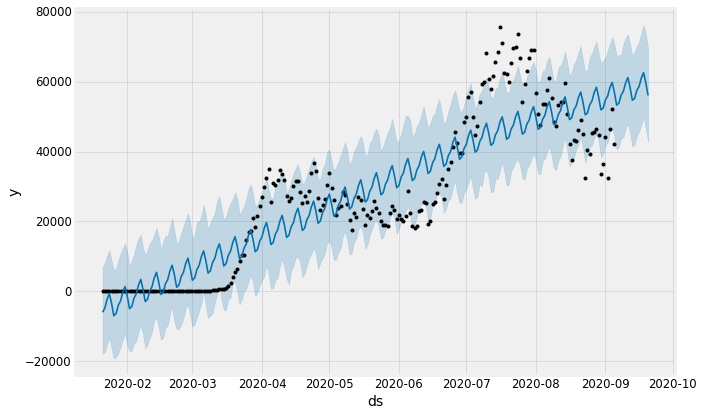

In [64]:
fig1 = model.plot(forecast)


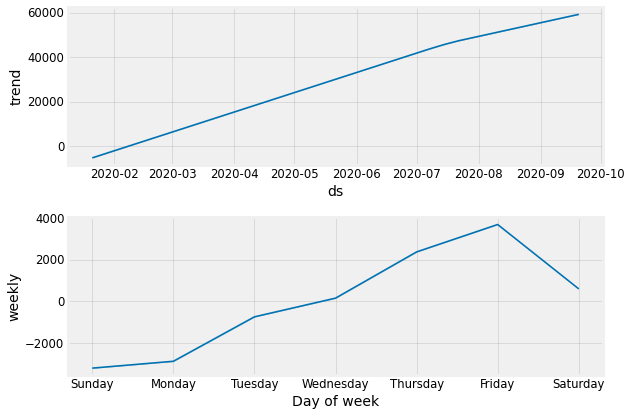

In [65]:
fig2 = model.plot_components(forecast)

In [66]:
#plot_plotly(model, forecast)

In [67]:
#plot_components_plotly(model, forecast)

In [68]:
np.sqrt(mean_squared_error(test, forecast['yhat'].tail(15)))


20549.567682080688

## TBATS

In [69]:
tbats = TBATS()
tbats_fit = tbats.fit(train)

In [70]:
preds_tbats = tbats_fit.forecast(steps = 15)

In [71]:
np.sqrt(mean_squared_error(test, preds_tbats))

11039.343188752451

In [72]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36839
2020-09-15    39221
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, dtype: int32

In [73]:
preds_tbats

array([48534.49965928, 46243.61367383, 42872.92847179, 44862.45162456,
       45462.84611931, 47658.24003515, 48481.77819373, 47357.90360872,
       46284.20757588, 45848.4564317 , 46750.79737105, 48205.43210518,
       48963.64451147, 48663.37160373, 47769.05949731])

## Helper functions for NN models

In [74]:
# preparing data to features and target to feed to the model
def prepare_data(timeseries_data, n_steps):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [75]:
def make_predictions(model, num_days, n_steps):
    x_input = Y[-n_steps:]
    x_input = x_input.reshape(1, n_steps, n_features)
    preds = []
    i = 0
    while i < num_days:
        pred = model.predict(x_input)[0][0]
        preds.append(pred)
        x_input = np.append(x_input[0], pred)
        x_input = x_input[-n_steps:]
        x_input = x_input.reshape(1, n_steps, n_features)
        i += 1
    
    return preds

## DNN

In [76]:
!nvidia-smi

Thu Sep 24 17:51:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 206... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   49C    P8    14W / 184W |    682MiB /  8192MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [77]:
n_steps = 20
X, Y = prepare_data(train, n_steps)

# reshaping X from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [78]:
dnn = Sequential()
dnn.add(Dense(32, input_shape=(n_steps, n_features), activation='relu'))
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(1))
dnn.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
dnn.fit(X,Y, epochs = 100, verbose=0 )

In [92]:
dnn_preds = test.copy()
dnn_preds = dnn_preds.replace(dnn_preds.values, make_predictions(dnn, 15, n_steps))

In [93]:
dnn_preds

date
2020-09-06    44795.234375
2020-09-07    32171.466797
2020-09-08    40167.878906
2020-09-09    38963.296875
2020-09-10    45079.726562
2020-09-11    45365.203125
2020-09-12    46312.160156
2020-09-13    44405.308594
2020-09-14    33277.574219
2020-09-15    36248.750000
2020-09-16    43796.550781
2020-09-17    32294.808594
2020-09-18    46105.261719
2020-09-19    51827.785156
2020-09-20    42056.820312
Name: case_day, dtype: float32

In [94]:
np.sqrt(mean_squared_error(dnn_preds, test))

8187.357611387116

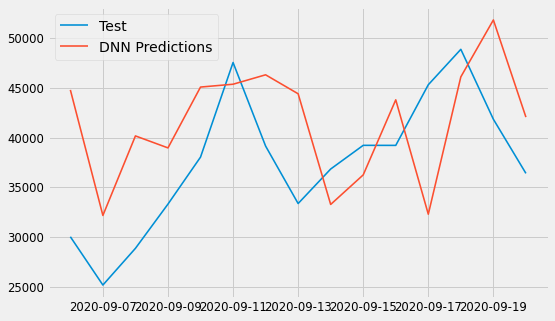

In [95]:
plt.plot(test, label = 'Test')
plt.plot(dnn_preds, label = 'DNN Predictions')
plt.legend(loc = 'upper left')
plt.show()

## RNN

In [87]:
n_steps = 15
X, Y = prepare_data(train, n_steps)

# reshaping X from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [88]:
rnn = Sequential()
rnn.add(SimpleRNN(32, input_shape=(n_steps, n_features), activation="relu"))
rnn.add(Dense(8, activation='relu'))
rnn.add(Dense(1))
rnn.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

In [89]:
rnn_fit = rnn.fit(X,Y, epochs = 100, verbose=0)

In [96]:
rnn_preds = test.copy()
rnn_preds = rnn_preds.replace(rnn_preds.values, make_predictions(rnn, 15, n_steps))

In [97]:
rnn_preds

date
2020-09-06    37333.171875
2020-09-07    37344.761719
2020-09-08    39651.546875
2020-09-09    42617.878906
2020-09-10    46484.488281
2020-09-11    50589.812500
2020-09-12    47027.542969
2020-09-13    40327.531250
2020-09-14    38955.289062
2020-09-15    40679.730469
2020-09-16    44369.414062
2020-09-17    48363.410156
2020-09-18    52158.390625
2020-09-19    48915.269531
2020-09-20    42046.753906
Name: case_day, dtype: float32

In [98]:
np.sqrt(mean_squared_error(rnn_preds, test))

6979.443685340836

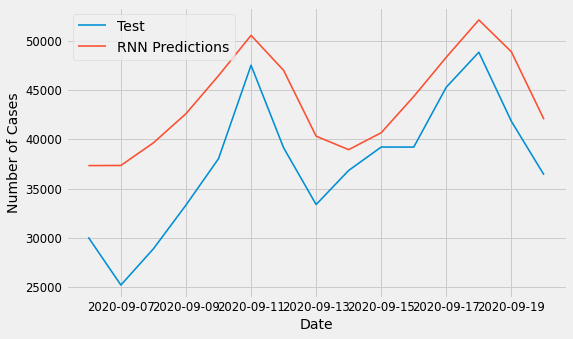

In [100]:
fig, ax = plt.subplots()
plt.plot(test, label = 'Test')
plt.plot(rnn_preds, label = 'RNN Predictions')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
#helper_plot(3)
plt.show()

## LSTM

### Building a model

In [101]:
n_steps = 10
X, Y = prepare_data(train, n_steps)

# reshaping X from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [102]:
lstm = Sequential()
lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm.add(LSTM(50, activation='relu'))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse' ,metrics = ['mse', 'mae'])
# fit model
lstm.fit(X, Y, epochs= 100, verbose=0)

In [103]:
lstm_preds = test.copy()
lstm_preds = lstm_preds.replace(lstm_preds.values, make_predictions(lstm, 15, n_steps))

In [104]:
np.sqrt(mean_squared_error(lstm_preds, test))

8556.895125273204

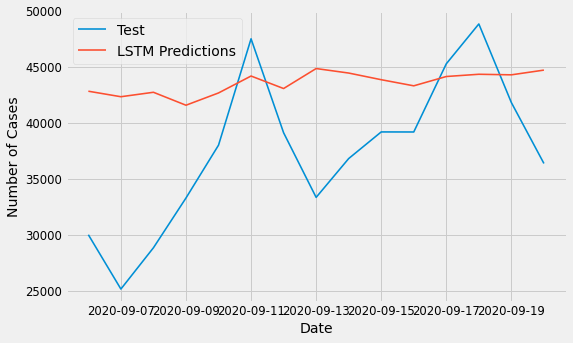

In [107]:
fig, ax = plt.subplots()
plt.plot(test, label = 'Test')
plt.plot(lstm_preds, label = 'LSTM Predictions')
plt.legend(loc = 'upper left')
#helper_plot(3)
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()